In [1]:
import re
import statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import datetime as dt

from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore, chi2, norm, multivariate_normal, spearmanr, pearsonr, shapiro
from scipy.optimize import minimize
from collections import defaultdict

In [2]:
# Load data, drop test entry
df = pd.read_csv("ads.csv", on_bad_lines="skip", delimiter=",")
df = df[df["Finished"] == "True"] #.drop(2)
df = df[(df["PROLIFIC_PID"] != "XXXXXPID") & (df["Finished"] == "True")]
print(f"Total responses valid: {len(df)}")
df.head()

Total responses valid: 197


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,111110v111111_3,Q359_First Click,Q359_Last Click,Q359_Page Submit,Q359_Click Count,Q2_First Click.3,Q2_Last Click.3,Q2_Page Submit.3,Q2_Click Count.3,PROLIFIC_PID
5,2025-06-13 15:04:44,2025-06-13 15:08:37,IP Address,NaN,100,233,True,2025-06-13 15:08:37,R_8GxfXEQXq24VXoq,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6135ce2a32b53777552a46b0
6,2025-06-13 15:04:08,2025-06-13 15:12:34,IP Address,NaN,100,506,True,2025-06-13 15:12:34,R_3g0wSbUefCEOVXX,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,3.436,0,68435d50e3c682b144a0b87a
7,2025-06-13 15:03:47,2025-06-13 15:14:58,IP Address,NaN,100,670,True,2025-06-13 15:14:58,R_8CcPqZNDeXqQmHw,NaN,...,NaN,NaN,NaN,NaN,NaN,1.892,1.892,2.335,1,60f06a479c4f3ec0a536d40a
8,2025-06-13 15:04:54,2025-06-13 15:15:30,IP Address,NaN,100,636,True,2025-06-13 15:15:31,R_8pncQr6UwLawYAP,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,5.623,0,5e8126a0d32cbc817a4df7b6
9,2025-06-13 15:04:35,2025-06-13 15:16:18,IP Address,NaN,100,703,True,2025-06-13 15:16:18,R_24PpEyytoYIQwAG,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,12.153,0,605e1fc0be766e80d0104df3


In [3]:
# Calculate average time to complete survey
times = df.iloc[2:][["StartDate", "EndDate"]]
times["total"] = pd.to_datetime(times["EndDate"]) - pd.to_datetime(times["StartDate"])
times["total"].sort_values().iloc[:-1].mean()

Timedelta('0 days 00:17:24.046391752')

## Drop evaluations that were made too quickly

In [4]:
all_times = []
qs = []

for row in df.T.iloc[17:].itertuples():
    if row[0].endswith("Page Submit"):
        
        # Questions 201-361 are the actual explanation pair questions
        qnum = int(row[0].split("_")[0][1:])
        
        if 201 <= qnum <= 362:
            times = np.array([float(i) for i in row[1:]])
            times_filtered = [i for i in times if not np.isnan(i)]
            all_times.extend(times_filtered)
            qs.extend([qnum] * len(times_filtered))

all_times = np.array(all_times)
qs = np.array(qs)
b10 = np.quantile(all_times, q=.1)
print(f"Bottom 10th percetile of time per question: {b10}s")
print(f"Number of evaluations that took longer than b10: {len(qs[all_times >= b10])}")

Bottom 10th percetile of time per question: 8.0042s
Number of evaluations that took longer than b10: 1721


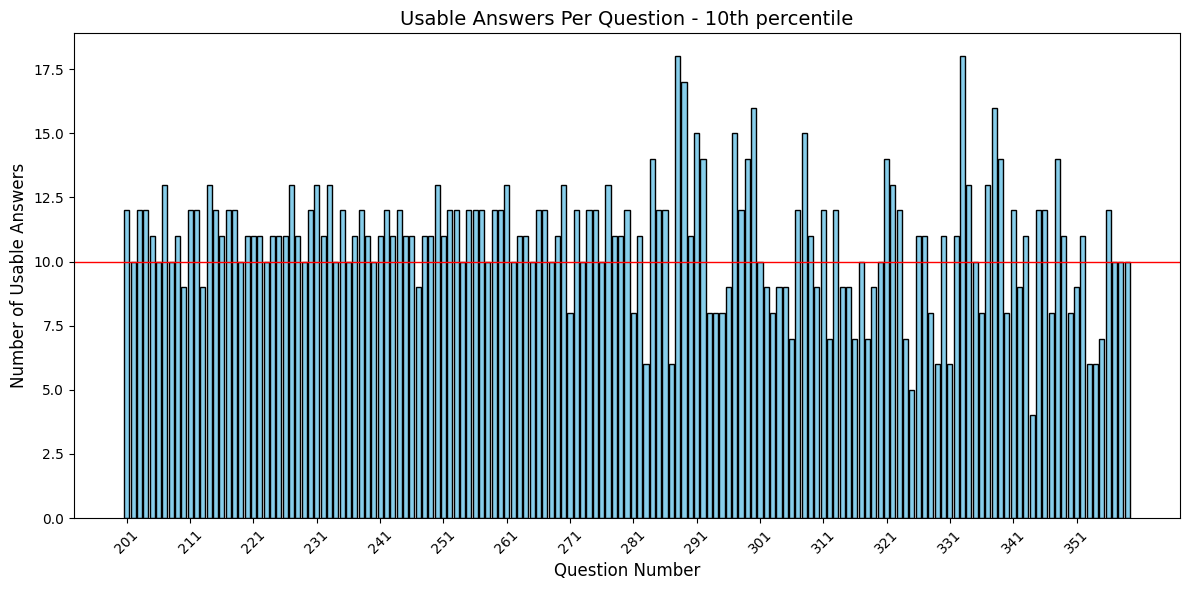

In [5]:
unique, counts = np.unique(qs[all_times >= b10], return_counts=True)

plt.figure(figsize=(12, 6))  # Increase figure size
plt.bar(unique, counts, color='skyblue', edgecolor='black')  # Add color and edge for clarity
plt.xlabel('Question Number', fontsize=12)
plt.ylabel('Number of Usable Answers', fontsize=12)
plt.title('Usable Answers Per Question - 10th percentile', fontsize=14)
plt.xticks(unique[::10], rotation=45, fontsize=10)  # Show every 10th tick, rotate for readability
plt.tight_layout()  # Adjust layout to avoid clipping

plt.axhline(y=10, color='red', linestyle='-', linewidth=1, label='Threshold (y=10)')

plt.show()

# General descriptives

In [6]:
# Education
df["Q3"].iloc[2:].value_counts()# .plot(kind="barh")

Q3
Bachelor's degree    86
Master's degree      58
High school          20
Doctorate            19
Vocational school     9
Other:                1
Prefer not to say     1
Name: count, dtype: int64

In [7]:
# Gender
df["Q1"].iloc[2:].value_counts() # .plot(kind="barh")

Q1
Female    100
Male       94
Name: count, dtype: int64

In [8]:
# Age
df["Q2"].iloc[2:].dropna().apply(int).describe()

count    193.000000
mean      35.891192
std       11.819986
min       18.000000
25%       28.000000
50%       33.000000
75%       41.000000
max       80.000000
Name: Q2, dtype: float64

In [9]:
# Job type
df["Q4"].iloc[2:].str.lower().value_counts()

Q4
finance                              22
healthcare                           17
information technology               11
it                                   10
education                             9
                                     ..
academic research                     1
software                              1
data science                          1
public relations /communications      1
data analyst,human resource           1
Name: count, Length: 106, dtype: int64

# Converting Likert to numbers

In [10]:
# Just the cognitive orientation questions per participant
df_co = df[["PROLIFIC_PID", "Q1.1", "Q2.1", "Q3.1", "Q4.1", "Q5", "Q6",
            "Q7", "Q8", "Q9", "Q10", "Q11", "Q12", 
            "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", 
            "Q19", "Q20", "Q21", "Q22", "Q23", "Q24", 
            "Q25"]].T

# Drop columns by testers
# df_co = df_co.rename(columns = {0 : "Question text"})

# # Set column names to prolific IDs 
df_co.columns = df_co.iloc[0].values.tolist()
df_co = df_co.drop(index = "PROLIFIC_PID")

# Rescale
df_co = df_co.replace({"Strongly disagree" : 0, "Somewhat disagree" : 1,
                       "Neither agree nor disagree" : 2, "Somewhat agree" : 3,
                       "Strongly agree" : 4}).iloc[:, 4:]

df_co.head()

C:\Users\roans\AppData\Local\Temp\ipykernel_9624\3489471624.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_co = df_co.replace({"Strongly disagree" : 0, "Somewhat disagree" : 1,


,605e1fc0be766e80d0104df3,66656db67864801db6a0e2c6,61241440b58a4621e8c2f050,5fe230ee29598a57972db630,66073c4673a44d32dc246496,6845230f58a84bd958387c70,677ced2e1a038fd5c8c3df1f,683f9cd0caffa2a9c37df1a1,669a9bee096a778e4939c25c,672541915a9a5ac8b878a28e,...,66735fc590d2b006289002b6,67f09ad02524e8b1d810e0a4,608c3c5e1cf6e05149f36b6a,67a507f52decb8dbaacc29e3,6612990fa0e1d2605331a833,6849c804c412a1bdd6d48f56,612058b64e8bd208d39fbe68,67adeb124ea5587ac8afa3ac,6755a0ba328d7effd6e56a20,67eac4d6bf3d1c4df7bd65df
Q1.1,1,1,0,1,2,3,0,1,0,1,...,0,0,1,0,1,1,1,1,0,1
Q2.1,2,4,4,2,3,3,4,4,3,3,...,3,4,2,4,3,2,3,4,4,2
Q3.1,2,0,3,3,3,1,1,1,1,1,...,3,0,1,3,1,1,4,2,2,1
Q4.1,3,1,0,1,3,3,0,0,2,1,...,1,0,1,0,3,3,2,1,2,1
Q5,1,4,4,4,3,2,4,3,3,3,...,2,3,2,4,1,2,3,3,3,3


In [11]:
co_groups = {"Need for Cognition" : {
               "Q1.1" : {"Reverse" : True},
               "Q2.1"  : {"Reverse" : False},
               "Q3.1" : {"Reverse" : True},
               "Q4.1" : {"Reverse" : True},
               "Q5"   : {"Reverse" : False}
               },
            "Need for closure" : {
               "Q6"  : {"Reverse" : False},
               "Q7"  : {"Reverse" : True},
               "Q8"  : {"Reverse" : True},
               "Q9"  : {"Reverse" : False}, 
               "Q10" : {"Reverse" : False},
               "Q11" : {"Reverse" : False},
               "Q12" : {"Reverse" : False}
            },
            "Susceptibility to persuasion" : {
                "Q13" : {"Reverse" : False},
                "Q14" : {"Reverse" : False},
                "Q15" : {"Reverse" : False},
                "Q16" : {"Reverse" : False}
            },
            "Skepticism" : {
                "Q17" : {"Reverse" : False},
                "Q18" : {"Reverse" : True},
                "Q19" : {"Reverse" : False},
                "Q20" : {"Reverse" : False},
                "Q21" : {"Reverse" : False}
            },
            "AI Expertise" : {
                "Q22" : {"Reverse" : False},
                "Q23" : {"Reverse" : False},
                "Q24" : {"Reverse" : False},
                "Q25" : {"Reverse" : True}
            }
        }

sub_dfs = {}

for group, questions in co_groups.items():
    temp = df_co.loc[list(questions.keys())]
    
    for question, reverse in questions.items():
        if reverse["Reverse"]:    
            temp.loc[question] = temp.loc[question].replace({4:0, 3:1, 1:3, 0:4})
            
#     temp = temp.drop(columns = "Question text")
    
    sub_dfs[group] = temp
    
sub_dfs["Need for Cognition"]

,605e1fc0be766e80d0104df3,66656db67864801db6a0e2c6,61241440b58a4621e8c2f050,5fe230ee29598a57972db630,66073c4673a44d32dc246496,6845230f58a84bd958387c70,677ced2e1a038fd5c8c3df1f,683f9cd0caffa2a9c37df1a1,669a9bee096a778e4939c25c,672541915a9a5ac8b878a28e,...,66735fc590d2b006289002b6,67f09ad02524e8b1d810e0a4,608c3c5e1cf6e05149f36b6a,67a507f52decb8dbaacc29e3,6612990fa0e1d2605331a833,6849c804c412a1bdd6d48f56,612058b64e8bd208d39fbe68,67adeb124ea5587ac8afa3ac,6755a0ba328d7effd6e56a20,67eac4d6bf3d1c4df7bd65df
Q1.1,3,3,4,3,2,1,4,3,4,3,...,4,4,3,4,3,3,3,3,4,3
Q2.1,2,4,4,2,3,3,4,4,3,3,...,3,4,2,4,3,2,3,4,4,2
Q3.1,2,4,1,1,1,3,3,3,3,3,...,1,4,3,1,3,3,0,2,2,3
Q4.1,1,3,4,3,1,1,4,4,2,3,...,3,4,3,4,1,1,2,3,2,3
Q5,1,4,4,4,3,2,4,3,3,3,...,2,3,2,4,1,2,3,3,3,3


In [12]:
all_scaled = pd.concat(list(sub_dfs.values()))

# Drop incomplete responses
all_scaled = all_scaled.drop(columns=all_scaled.columns[all_scaled.isna().sum() > 0]).T

# Confirmatory Factor Analysis

In [13]:
co_groups_updated = defaultdict(dict)

counter = 0

to_drop = []

for group, questions in co_groups.items():
    for question in questions:
        if question not in ["Q9", "Q10", "Q12", "Q18"]:
            
            co_groups_updated[group][question] = co_groups[group][question]
        
        else:
            print(f"Dropping: {question}")
            to_drop.append(question)

        counter += 1
        
co_groups = co_groups_updated
all_scaled_corrected = all_scaled.drop(columns=to_drop)

Dropping: Q9
Dropping: Q10
Dropping: Q12
Dropping: Q18


# Calculating concept scores per participant

In [14]:
# Calculate average scores for each concept
concept_scores = pd.DataFrame()

for concept, questions in co_groups.items():
    concept_scores[concept] = all_scaled[list(questions.keys())].sum(axis=1) / (len(questions.keys()) * 4)

# Output results
concept_scores.describe()

,Need for Cognition,Need for closure,Susceptibility to persuasion,Skepticism,AI Expertise
count,192.000000,192.000000,192.000000,192.00000,192.000000
mean,0.690625,0.512370,0.690755,0.77832,0.673177
std,0.161523,0.130795,0.154918,0.13624,0.146814
min,0.300000,0.187500,0.000000,0.43750,0.187500
25%,0.550000,0.437500,0.625000,0.68750,0.625000
50%,0.700000,0.500000,0.687500,0.75000,0.687500
75%,0.800000,0.562500,0.812500,0.87500,0.750000
max,1.000000,0.875000,1.000000,1.00000,1.000000


In [15]:
for col in concept_scores.columns:
    print(f"{col}: {shapiro(concept_scores[col])}")

Need for Cognition: ShapiroResult(statistic=0.9713271567417726, pvalue=0.0005657644178155005)
Need for closure: ShapiroResult(statistic=0.9746369139430935, pvalue=0.0014698627337198745)
Susceptibility to persuasion: ShapiroResult(statistic=0.9570547070391718, pvalue=1.4373655675069748e-05)
Skepticism: ShapiroResult(statistic=0.9613460800605551, pvalue=4.049711771437401e-05)
AI Expertise: ShapiroResult(statistic=0.9638199152600413, pvalue=7.545211370386067e-05)


# Data restructuring (evaluations)

In [16]:
# Check for columns related to explanation pair evaluations and participant-level identifiers
pair_columns = [col for col in df.columns if ("v" in str(col)) or ("Page Submit" in str(col))]
participant_columns = ['ResponseId', 'PROLIFIC_PID']
subset_data = df[participant_columns + pair_columns]

# Find submit times of all questions
submits = sorted([i for i in pair_columns if re.match("Q\\d{3}_Page Submit", i)])[:-4]
qs = sorted(list(set([i[:-2] for i in pair_columns if re.match("\\d{6}v\\d{6}_\\d", i)])))

lookup = dict(zip(submits, qs))

# Actually remove any evaluations that took less than b10 from the dataset
for row in subset_data.iterrows():

    index, row = row
    
    for submit in submits:
        if float(row[submit]) < b10:
            subset_data.loc[index, f"{lookup[submit]}_1"] = np.nan
            subset_data.loc[index, f"{lookup[submit]}_2"] = np.nan
            subset_data.loc[index, f"{lookup[submit]}_3"] = np.nan

subset_data

C:\Users\roans\AppData\Local\Temp\ipykernel_9624\2315859127.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[index, f"{lookup[submit]}_1"] = np.nan
C:\Users\roans\AppData\Local\Temp\ipykernel_9624\2315859127.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.loc[index, f"{lookup[submit]}_2"] = np.nan
C:\Users\roans\AppData\Local\Temp\ipykernel_9624\2315859127.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,ResponseId,PROLIFIC_PID,Q2_Page Submit,Q2_Page Submit.1,Q5_Page Submit,Q26_Page Submit,Q2_Page Submit.2,000000v000001_1,000000v000001_2,000000v000001_3,...,Q357_Page Submit,111101v111111_1,111101v111111_2,111101v111111_3,Q358_Page Submit,111110v111111_1,111110v111111_2,111110v111111_3,Q359_Page Submit,Q2_Page Submit.3
5,R_8GxfXEQXq24VXoq,6135ce2a32b53777552a46b0,6.198,225.81,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,R_3g0wSbUefCEOVXX,68435d50e3c682b144a0b87a,30.281,6.585,32.934,117.438,33.533,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.436
7,R_8CcPqZNDeXqQmHw,60f06a479c4f3ec0a536d40a,4.573,4.534,13.459,127.815,41.817,NaN,NaN,NaN,...,52.835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.335
8,R_8pncQr6UwLawYAP,5e8126a0d32cbc817a4df7b6,5.244,76.694,29.741,173.852,8.139,Explanation B,Explanation A,Explanation B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.623
9,R_24PpEyytoYIQwAG,605e1fc0be766e80d0104df3,25.341,26.867,24.754,156.88,12.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,R_3QR4iVcHEkHuJaK,6849c804c412a1bdd6d48f56,8.696,121.826,92.795,370.2,210.873,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.589
198,R_2h4p069fjXG6Bnc,612058b64e8bd208d39fbe68,20.641,16.424,10.605,219.363,50.179,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.028
199,R_8PgYBfRlpmFoUYg,67adeb124ea5587ac8afa3ac,211.836,18.221,15.899,187.19,38.988,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.065
200,R_8IiFpbnVm20gZqh,6755a0ba328d7effd6e56a20,18.001,14.101,89.817,340.386,11.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Explanation A,Explanation A,Explanation A,13.001,15.684


In [17]:
# Reshape the explanation pair data into long format

# Melt explanation pair columns to create a long-format dataframe

long_data = pd.melt(
    subset_data,
    id_vars=participant_columns,  # Keep participant identifiers
    value_vars=pair_columns,  # Explanation pair columns
    var_name="ExplanationPair_Metric",  # New column for explanation pair + metric
    value_name="Evaluation"  # Column for evaluation (trust, transparency, usefulness)
)

# Split ExplanationPair_Metric into ExplanationPair and MetricType
long_data[['ExplanationPair', 'MetricType']] = long_data['ExplanationPair_Metric'].str.extract(r'(.*)_([1-3])')

# Map MetricType to human-readable labels
metric_map = {
    "1": "Trustworthiness",
    "2": "Transparency",
    "3": "Usefulness"
}

long_data['MetricType'] = long_data['MetricType'].map(metric_map)

# Drop unnecessary columns
long_data = long_data.drop(columns = ["ExplanationPair_Metric"])
long_data = long_data.dropna(subset = ["Evaluation", "ExplanationPair"])

# Display a sample of the reshaped data
long_data.sort_values(by=["PROLIFIC_PID", "ExplanationPair"]).head()

,ResponseId,PROLIFIC_PID,Evaluation,ExplanationPair,MetricType
6598,R_2Y35HBafRShz7Ht,58cd0bc2a47dbb000171dc8b,Explanation A,000001v001001,Trustworthiness
6795,R_2Y35HBafRShz7Ht,58cd0bc2a47dbb000171dc8b,Explanation A,000001v001001,Transparency
6992,R_2Y35HBafRShz7Ht,58cd0bc2a47dbb000171dc8b,Explanation A,000001v001001,Usefulness
12114,R_2Y35HBafRShz7Ht,58cd0bc2a47dbb000171dc8b,Explanation A,000011v001011,Trustworthiness
12311,R_2Y35HBafRShz7Ht,58cd0bc2a47dbb000171dc8b,Explanation A,000011v001011,Transparency


In [18]:
def flip_values(pair):
    """
    The bits used to represent the explanations are counterintuitive for
    Persuasion, Detail, and Formality. Hence, we flip them. As a result, the coding is:
    bit 0: 0 = low-stakes,       1 = high-stakes
    bit 1: 0 = short,            1 = long
    bit 2: 0 = running,          1 = bulleted
    bit 3: 0 = informal,         1 = formal
    bit 4: 0 = aggregated,       1 = comprehensive
    bit 5: 0 = decision-support, 1 = persuasive
    """
    
    pair = list(pair)
    pair[3], pair[10] = "0" if int(pair[3]) else "1", "0" if int(pair[10]) else "1"
    pair[4], pair[11] = "0" if int(pair[4]) else "1", "0" if int(pair[11]) else "1"
    pair[5], pair[12] = "0" if int(pair[5]) else "1", "0" if int(pair[12]) else "1"
 
    
    return "".join(pair)
    
long_data["ExplanationPair"] = long_data["ExplanationPair"].apply(flip_values)

In [19]:
def pair_parser(explanation_pair):
    """
    Converts the string-like representation of the explanation pair
    to a categorical variable indicating which of the design dimensions
    has been 'flipped' between the two explanations. In this flip, explanation
    B always has a 1 ('higher' value) and explanation A a 0 ('lower' value)
    """
    
    explanation_a, explanation_b = explanation_pair.split("v")
    feature_names = ["Domain", "Length", "Structure", "Formality", "Detail", "Persuasiveness"]
    
    features_a = {f"{feature}": int(bit) for feature, bit in zip(feature_names, explanation_a)}
    features_b = {f"{feature}": int(bit) for feature, bit in zip(feature_names, explanation_b)}       

    return {"Domain": "high" if features_a["Domain"] else "low", 
            "flipped_dim": feature_names[np.argmax([features_a[feature] != features_b[feature] 
                                         for feature in feature_names])]}
        
# Apply the function to the ExplanationPair column and expand the result into new columns
binary_features = long_data['ExplanationPair'].map(pair_parser).apply(pd.Series)

# Concatenate the binary features back into the main dataframe
long_data = pd.concat([long_data, binary_features], axis=1)

# Drop any unnecessary intermediate columns
long_data = long_data.drop(columns=["ResponseId", "Features_A", "Features_B"],
                           errors="ignore")

In [20]:
# Include flipped_dim and domain as a column
cols = ["PROLIFIC_PID", "ExplanationPair", "Need for Cognition",
        "Need for closure", "Susceptibility to persuasion",
        "Skepticism", "AI Expertise", "Domain", "flipped_dim", 
        "MetricType", "Evaluation"]
    
# Merge evaluations with cognitive orientations and restructure
final_data = long_data.join(concept_scores, 
                            on="PROLIFIC_PID", 
                            how="left").sort_values(
    by=["PROLIFIC_PID", "ExplanationPair"]
)[cols]

final_data["Evaluation"] = final_data["Evaluation"].replace({"Explanation A": 0, "Explanation B": 1})

final_data.head()

C:\Users\roans\AppData\Local\Temp\ipykernel_9624\1546677600.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_data["Evaluation"] = final_data["Evaluation"].replace({"Explanation A": 0, "Explanation B": 1})


,PROLIFIC_PID,ExplanationPair,Need for Cognition,Need for closure,Susceptibility to persuasion,Skepticism,AI Expertise,Domain,flipped_dim,MetricType,Evaluation
12114,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Trustworthiness,0
12311,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Transparency,0
12508,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Usefulness,0
6598,58cd0bc2a47dbb000171dc8b,000110v001110,0.75,0.5,0.9375,0.875,1.0,low,Structure,Trustworthiness,0
6795,58cd0bc2a47dbb000171dc8b,000110v001110,0.75,0.5,0.9375,0.875,1.0,low,Structure,Transparency,0


In [21]:
def decision_flipper(row):
    """
    Since we flipped three dimensions, their direction in terms of evaluation
    has also been flipped (i.e., explanation A (baseline) has "become" explanation B (treatment)
    since that one now has the 1 instead of the 0. As a result, we also have to flip the order of the 
    explanations and the evaluation for it, so that a 1 again indicates a preference for the treatment. 
    """

    split = row["ExplanationPair"].split("v")
    reversed_order = f"{split[1]}v{split[0]}"
    
    if row["flipped_dim"] in ["Formality", "Detail", "Persuasiveness"]:
        return 0 if row["Evaluation"] else 1, reversed_order 
    else:
        return row["Evaluation"], row["ExplanationPair"]

# Apply flipper
for row in final_data.iterrows():
    fixed_eval, fixed_explanation = decision_flipper(row[1])
    
    final_data.loc[row[0], "Evaluation"] = fixed_eval
    final_data.loc[row[0], "ExplanationPair"] = fixed_explanation

final_data.columns = [col.replace(" ", "_") for col in final_data.columns]    
    
final_data.head()

,PROLIFIC_PID,ExplanationPair,Need_for_Cognition,Need_for_closure,Susceptibility_to_persuasion,Skepticism,AI_Expertise,Domain,flipped_dim,MetricType,Evaluation
12114,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Trustworthiness,0
12311,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Transparency,0
12508,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Usefulness,0
6598,58cd0bc2a47dbb000171dc8b,000110v001110,0.75,0.5,0.9375,0.875,1.0,low,Structure,Trustworthiness,0
6795,58cd0bc2a47dbb000171dc8b,000110v001110,0.75,0.5,0.9375,0.875,1.0,low,Structure,Transparency,0


# Calculate polychoric correlation

In [22]:
# Store correlation dataset as csv
correlation_df = final_data[["PROLIFIC_PID", 
                             "MetricType", 
                             "Evaluation",
                             "ExplanationPair"]].pivot(
                     columns="MetricType", 
                     values="Evaluation",
                     index=["PROLIFIC_PID", "ExplanationPair"]
                 )

correlation_df.to_csv("../results/correlation_df.csv")

In [23]:
%%R
library(polycor)

data <- read.csv("correlation_df.csv")

calculate_p <- function(corr) {
  rho = corr$rho
  SE = sqrt(corr$var)
  z <- rho / SE
  p = 2 * (1 - pnorm(abs(z)))
  return(as.numeric(p))
}

corr_use_trans = polychor(data$Usefulness, data$Transparency, std.err=TRUE)
p_use_trans = calculate_p(corr_use_trans)

corr_use_trust = polychor(data$Usefulness, data$Trustworthiness, std.err=TRUE)
p_use_trust = calculate_p(corr_use_trust)

corr_trust_trans = polychor(data$Trustworthiness, data$Transparency, std.err=TRUE)
p_trust_trans = calculate_p(corr_trust_trans)

print(corr_use_trans$rho)
print(p_use_trans)
print(corr_use_trust$rho)
print(p_use_trust)
print(corr_trust_trans$rho)
print(p_trust_trans)

UsageError: Cell magic `%%R` not found.


In [24]:
final_data = final_data.reset_index().drop(columns="index")
final_data.columns = [i.replace(" ", "_") for i in final_data.columns]
final_data = final_data.dropna()

# Calculate share of evaluations where all metrics aligned
decisions = final_data.groupby(["PROLIFIC_PID", "ExplanationPair"])["Evaluation"].sum().values
np.isin(decisions, [0, 3]).mean()

0.702276707530648

# Logistic Regression

In [25]:
# Store dataframe used for logistic regressions
final_data.to_csv("../results/evaluations.csv")

final_data[final_data["Domain"] == "low"].to_csv("../results/evaluations_low.csv")
final_data[final_data["Domain"] == "high"].to_csv("../results/evaluations_low.csv")

final_data.head()

,PROLIFIC_PID,ExplanationPair,Need_for_Cognition,Need_for_closure,Susceptibility_to_persuasion,Skepticism,AI_Expertise,Domain,flipped_dim,MetricType,Evaluation
0,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Trustworthiness,0
1,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Transparency,0
2,58cd0bc2a47dbb000171dc8b,000100v001100,0.75,0.5,0.9375,0.875,1.0,low,Structure,Usefulness,0
3,58cd0bc2a47dbb000171dc8b,000110v001110,0.75,0.5,0.9375,0.875,1.0,low,Structure,Trustworthiness,0
4,58cd0bc2a47dbb000171dc8b,000110v001110,0.75,0.5,0.9375,0.875,1.0,low,Structure,Transparency,0


## Fitting the mixed-effects logistic regression model (without personalization)

In [ ]:
%%R

# Load required libraries
library(lme4)
library(dplyr)
library(stats)

# Load the data
data <- read.csv("../results/evaluations.csv")

# Set categorical variables
data$flipped_dim <- factor(data$flipped_dim, 
                           levels = c("Structure", "Length", "Formality", "Detail", "Persuasiveness"))

data$MetricType <- factor(data$MetricType, 
                          levels = c("Trustworthiness", "Usefulness", "Transparency"))

data$Domain <- factor(data$Domain, 
                      levels = c("high", "low"))

# Fit the mixed-effects logistic regression model
model <- glmer(Evaluation ~ flipped_dim + MetricType + Domain +
                 (1 | PROLIFIC_PID), 
               data = data, 
               family = binomial,
               control = glmerControl(optimizer = "bobyqa", 
                                      optCtrl = list(maxfun = 1e6))
               )

print(summary(model))

# Extract fixed effect coefficients
coefs <- fixef(model)

# Extract variance-covariance matrix
vcov_matrix <- vcov(model)

# Separate main effects and interaction terms
main_effects <- coefs[grepl("^flipped_dim", names(coefs))]

# Derive the missing coefficient for 'Structure' (main effect)
structure_main_effect <- -sum(main_effects)

# Calculate standard errors for the missing coefficients
# Main effect for 'Structure'
main_effect_vars <- diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]
main_effect_covs <- vcov_matrix[grepl("^flipped_dim", names(coefs)), grepl("^flipped_dim", names(coefs))]
main_effect_se <- sqrt(sum(main_effect_vars) + 2 * sum(main_effect_covs[lower.tri(main_effect_covs)]))

# Calculate z-scores and p-values
structure_main_z <- structure_main_effect / main_effect_se
structure_main_p <- 2 * (1 - pnorm(abs(structure_main_z)))

# Combine results into a data frame
# Main effects
main_results <- data.frame(
  Predictor = gsub("flipped_dim", "", names(main_effects)),
  Coefficient = main_effects,
  SE = sqrt(diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]),
  z = main_effects / sqrt(diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]),
  p_value = 2 * (1 - pnorm(abs(main_effects / sqrt(diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]))))
)

# Missing coefficients (Structure)
structure_results <- data.frame(
  Predictor = "Structure",
  Coefficient = structure_main_effect,
  SE = main_effect_se,
  z = structure_main_z,
  p_value = structure_main_p
)

# Combine all results, explicitly including the intercept
intercept_result <- data.frame(
  Predictor = "(Intercept)",
  Coefficient = coefs["(Intercept)"],
  SE = sqrt(diag(vcov_matrix)["(Intercept)"]),
  z = coefs["(Intercept)"] / sqrt(diag(vcov_matrix)["(Intercept)"]),
  p_value = 2 * (1 - pnorm(abs(coefs["(Intercept)"] / sqrt(diag(vcov_matrix)["(Intercept)"]))))
)

# Combine all results
final_results <- bind_rows(intercept_result, main_results, structure_results)

# Format the table and include significance levels
final_results <- final_results %>%
  mutate(
    Coefficient = round(Coefficient, 3),
    SE = round(SE, 3),
    z = round(z, 3),
    p_value = round(p_value, 3),
    Significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ ""
    )
  )

# Fix ordering
rownames(final_results) <- NULL
custom_order <- c("(Intercept)", "Detail", "Formality", "Length", "Persuasiveness", "Structure")

final_results <- final_results[match(custom_order, final_results$Predictor), ]

write.csv(final_results, "../results/final_results_general.csv", row.names = FALSE)

In [131]:
Routput = pd.read_csv("../results/final_results_general_ads.csv")

corr = statsmodels.stats.multitest.fdrcorrection(Routput["p_value"],
                                                 alpha=0.05, 
                                                 method='indep',
                                                 is_sorted=False)

Routput["Odds Ratio"] = np.exp(Routput["Coefficient"])
Routput["Corrected p-value"] = corr[1]
Routput["Reject H0"] = corr[0]

Routput[["Predictor", "Coefficient", "SE", "Odds Ratio", "Corrected p-value"]]

,Predictor,Coefficient,SE,Odds Ratio,Corrected p-value
0,(Intercept),0.228,0.101,1.256085,0.024
1,Detail,1.031,0.103,2.803868,0.000
2,Formality,0.651,0.099,1.917457,0.000
3,Length,0.985,0.102,2.677812,0.000
4,Persuasiveness,-0.661,0.098,0.516335,0.000
5,Structure,-2.006,0.314,0.134526,0.000


## Fitting the mixed-effects logistic regression model (with personalization)

In [ ]:
%%R

# Load required libraries
library(lme4)
library(dplyr)
library(stats)

# Load the data
data <- read.csv("../results/evaluations.csv")

# Set categorical variables
data$flipped_dim <- factor(data$flipped_dim, 
                           levels = c("Structure", "Length", "Formality", "Detail", "Persuasiveness"))

data$MetricType <- factor(data$MetricType, 
                          levels = c("Trustworthiness", "Usefulness", "Transparency"))

data$Domain <- factor(data$Domain, 
                      levels = c("high", "low"))

# Fit the mixed-effects logistic regression model
model <- glmer(Evaluation ~ Need_for_Cognition + Need_for_closure + 
                 Susceptibility_to_persuasion + Skepticism + 
                 AI_Expertise + flipped_dim + MetricType + Domain +
                 (Need_for_Cognition + Need_for_closure + Susceptibility_to_persuasion + 
                    Skepticism + AI_Expertise):flipped_dim + 
                 (1 | PROLIFIC_PID), 
               data = data, 
               family = binomial,
               control = glmerControl(optimizer = "bobyqa", 
                                      optCtrl = list(maxfun = 1e6))
               )

print(summary(model))

# Extract fixed effect coefficients
coefs <- fixef(model)

# Extract variance-covariance matrix
vcov_matrix <- vcov(model)

# Separate main effects and interaction terms
main_effects <- coefs[grepl("^flipped_dim", names(coefs))]
interaction_terms <- coefs[grepl(":flipped_dim", names(coefs))]
continuous_effects <- coefs[!grepl("flipped_dim", names(coefs)) & !grepl(":", names(coefs))]

# Derive the missing coefficient for 'Structure' (main effect)
structure_main_effect <- -sum(main_effects)

# Derive the missing coefficients for 'Structure' (interactions)
predictors <- c("Need_for_Cognition", "Need_for_closure", 
                "Susceptibility_to_persuasion", "Skepticism", "AI_Expertise")
structure_interactions <- sapply(predictors, function(pred) {
  interaction_coefs <- coefs[grepl(paste0(pred, ":flipped_dim"), names(coefs))]
  -sum(interaction_coefs)
})

# Calculate standard errors for the missing coefficients
# Main effect for 'Structure'
main_effect_vars <- diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]
main_effect_covs <- vcov_matrix[grepl("^flipped_dim", names(coefs)), grepl("^flipped_dim", names(coefs))]
main_effect_se <- sqrt(sum(main_effect_vars) + 2 * sum(main_effect_covs[lower.tri(main_effect_covs)]))

# Interactions for 'Structure'
interaction_se <- sapply(1:length(predictors), function(i) {
  pred <- predictors[i]
  interaction_indices <- which(grepl(paste0(pred, ":flipped_dim"), names(coefs)))
  interaction_vars <- diag(vcov_matrix)[interaction_indices]
  interaction_covs <- vcov_matrix[interaction_indices, interaction_indices]
  sqrt(sum(interaction_vars) + 2 * sum(interaction_covs[lower.tri(interaction_covs)]))
})

# Calculate z-scores and p-values
structure_main_z <- structure_main_effect / main_effect_se
structure_main_p <- 2 * (1 - pnorm(abs(structure_main_z)))

interaction_z <- structure_interactions / interaction_se
interaction_p <- 2 * (1 - pnorm(abs(interaction_z)))

# Combine results into a data frame
# Main effects
main_results <- data.frame(
  Predictor = gsub("flipped_dim", "", names(main_effects)),
  Coefficient = main_effects,
  SE = sqrt(diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]),
  z = main_effects / sqrt(diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]),
  p_value = 2 * (1 - pnorm(abs(main_effects / sqrt(diag(vcov_matrix)[grepl("^flipped_dim", names(coefs))]))))
)

# Continuous predictors (retain as-is)
continuous_results <- data.frame(
  Predictor = names(continuous_effects),
  Coefficient = continuous_effects,
  SE = sqrt(diag(vcov_matrix)[!grepl("flipped_dim", names(coefs)) & !grepl(":", names(coefs))]),
  z = continuous_effects / sqrt(diag(vcov_matrix)[!grepl("flipped_dim", names(coefs)) & !grepl(":", names(coefs))]),
  p_value = 2 * (1 - pnorm(abs(continuous_effects / sqrt(diag(vcov_matrix)[!grepl("flipped_dim", names(coefs)) & !grepl(":", names(coefs))]))))
)

# Interaction terms
interaction_results <- data.frame(
  Predictor = gsub(":flipped_dim", ":", names(interaction_terms)),
  Coefficient = interaction_terms,
  SE = sqrt(diag(vcov_matrix)[grepl(":flipped_dim", names(coefs))]),
  z = interaction_terms / sqrt(diag(vcov_matrix)[grepl(":flipped_dim", names(coefs))]),
  p_value = 2 * (1 - pnorm(abs(interaction_terms / sqrt(diag(vcov_matrix)[grepl(":flipped_dim", names(coefs))]))))
)

# Missing coefficients (Structure)
structure_results <- data.frame(
  Predictor = c("Structure", paste0(predictors, ":Structure")),
  Coefficient = c(structure_main_effect, structure_interactions),
  SE = c(main_effect_se, interaction_se),
  z = c(structure_main_z, interaction_z),
  p_value = c(structure_main_p, interaction_p)
)

# Combine all results
final_results <- bind_rows(continuous_results, main_results, interaction_results, structure_results)

# Format the table and include significance levels
final_results <- final_results %>%
  mutate(
    Coefficient = round(Coefficient, 3),
    SE = round(SE, 3),
    z = round(z, 3),
    p_value = round(p_value, 3),
    Significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ ""
    )
  )

# Fix ordering
rownames(final_results) <- NULL
custom_order <- c("(Intercept)", "Need_for_Cognition", "Need_for_closure", "Susceptibility_to_persuasion",
                  "Skepticism", "AI_Expertise", "Detail", "Formality", "Length", "Persuasiveness", "Structure",
                  "Need_for_Cognition:Detail", "Need_for_Cognition:Formality", "Need_for_Cognition:Length",
                  "Need_for_Cognition:Persuasiveness", "Need_for_Cognition:Structure", "Need_for_closure:Detail", 
                  "Need_for_closure:Formality", "Need_for_closure:Length", "Need_for_closure:Persuasiveness", 
                  "Need_for_closure:Structure", "Susceptibility_to_persuasion:Detail", "Susceptibility_to_persuasion:Formality",
                  "Susceptibility_to_persuasion:Length", "Susceptibility_to_persuasion:Persuasiveness",
                  "Susceptibility_to_persuasion:Structure", "Skepticism:Detail", "Skepticism:Formality", 
                  "Skepticism:Length", "Skepticism:Persuasiveness", "Skepticism:Structure", "AI_Expertise:Detail",
                  "AI_Expertise:Formality","AI_Expertise:Length","AI_Expertise:Persuasiveness","AI_Expertise:Structure")

final_results <- final_results[match(custom_order, final_results$Predictor), ]

write.csv(final_results, "../results/final_results_personal.csv", row.names = FALSE)

In [29]:
Routput = pd.read_csv("../results/final_results_personal_ads.csv")

corr = statsmodels.stats.multitest.fdrcorrection(Routput["p_value"],
                                                 alpha=0.05, 
                                                 method='indep',
                                                 is_sorted=False)

Routput["Odds Ratio"] = np.exp(Routput["Coefficient"])
Routput["Corrected p-value"] = corr[1]
Routput["Reject H0"] = corr[0]

Routput[["Predictor", "Coefficient", "SE", "Odds Ratio", "z", "Corrected p-value", "Reject H0"]]

,Predictor,Coefficient,SE,Odds Ratio,z,Corrected p-value,Reject H0
0,(Intercept),0.484,0.714,1.622552,0.677,0.584129,False
1,Need_for_Cognition,-0.170,0.611,0.843665,-0.278,0.826941,False
2,Need_for_closure,0.504,0.623,1.655329,0.809,0.584129,False
3,Susceptibility_to_persuasion,0.255,0.538,1.290462,0.474,0.714375,False
4,Skepticism,-1.321,0.702,0.266868,-1.882,0.180000,False
5,AI_Expertise,0.692,0.593,1.997707,1.167,0.473400,False
6,Detail,1.009,0.901,2.742857,1.119,0.473400,False
7,Formality,0.595,0.880,1.813031,0.677,0.584129,False
8,Length,0.616,0.847,1.851507,0.728,0.584129,False
9,Persuasiveness,-1.638,0.866,0.194368,-1.892,0.180000,False
